### Load generated molecules and predicted activity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

EPOCHS = 25
targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']

dataframes = {
    target: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv(
    f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/Unconditional.csv'
)

In [2]:
aggs = ["SUM", "MEAN", "MAX"]


multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

def dataframes_statistics(dataframes):
    valid_stats = []
    unique_stats = []
    for disease in dataframes:
        df = dataframes[disease]
        col_preds = df.columns[1]
        
        total_count = len(df)
        valid_count = len(df[~df[col_preds].isna()])
        unique_count = len(df[~df.duplicated(subset='SMILES')])
        
        valid_stats.append({
            'Disease': disease,
            'Valid %': (valid_count / total_count)
        })
        unique_stats.append({
            'Disease': disease, 
            'Unique %': (unique_count / total_count)
        })
    
    return pd.DataFrame(valid_stats), pd.DataFrame(unique_stats)

valid_target_mols, unique_target_mols = dataframes_statistics(dataframes)
valid_mt_mols, unique_mt_mols = dataframes_statistics(dataframes_mt)

display(
    pd.concat([valid_mt_mols, valid_target_mols], ignore_index=True)
        .set_index("Disease")
        .sort_index()
        .style
        .background_gradient(cmap='YlOrRd', axis=None)
        .format('{:.1%}')
        .set_caption("Valid generated molecules")
)

# print(
#     pd.concat([valid_mt_mols, valid_target_mols], ignore_index=True)
#         .set_index("Disease")
#         .to_csv()
# )
display(
    pd.concat([unique_mt_mols, unique_target_mols], ignore_index=True)
        .set_index("Disease")
        .sort_index()
        .style
        .background_gradient(cmap='YlOrRd', axis=None)
        .format('{:.1%}')
        .set_caption("Valid generated molecules")
)

# print(
# pd.concat([unique_mt_mols, unique_target_mols], ignore_index=True)
#     .set_index("Disease")
#     .to_csv()
# )

,Valid %
Disease,
AChE,93.1%
AChE_MAOB_MAX,96.2%
AChE_MAOB_MEAN,96.7%
AChE_MAOB_SUM,92.2%
D2R,96.4%
D2R_D3R_MAX,97.0%
D2R_D3R_MEAN,97.2%
D2R_D3R_SUM,92.5%
D2R__5HT2A_MAX,96.7%


,Unique %
Disease,
AChE,82.2%
AChE_MAOB_MAX,96.2%
AChE_MAOB_MEAN,96.9%
AChE_MAOB_SUM,87.0%
D2R,82.8%
D2R_D3R_MAX,84.8%
D2R_D3R_MEAN,84.4%
D2R_D3R_SUM,75.9%
D2R__5HT2A_MAX,90.0%


### Assess mean target modulation

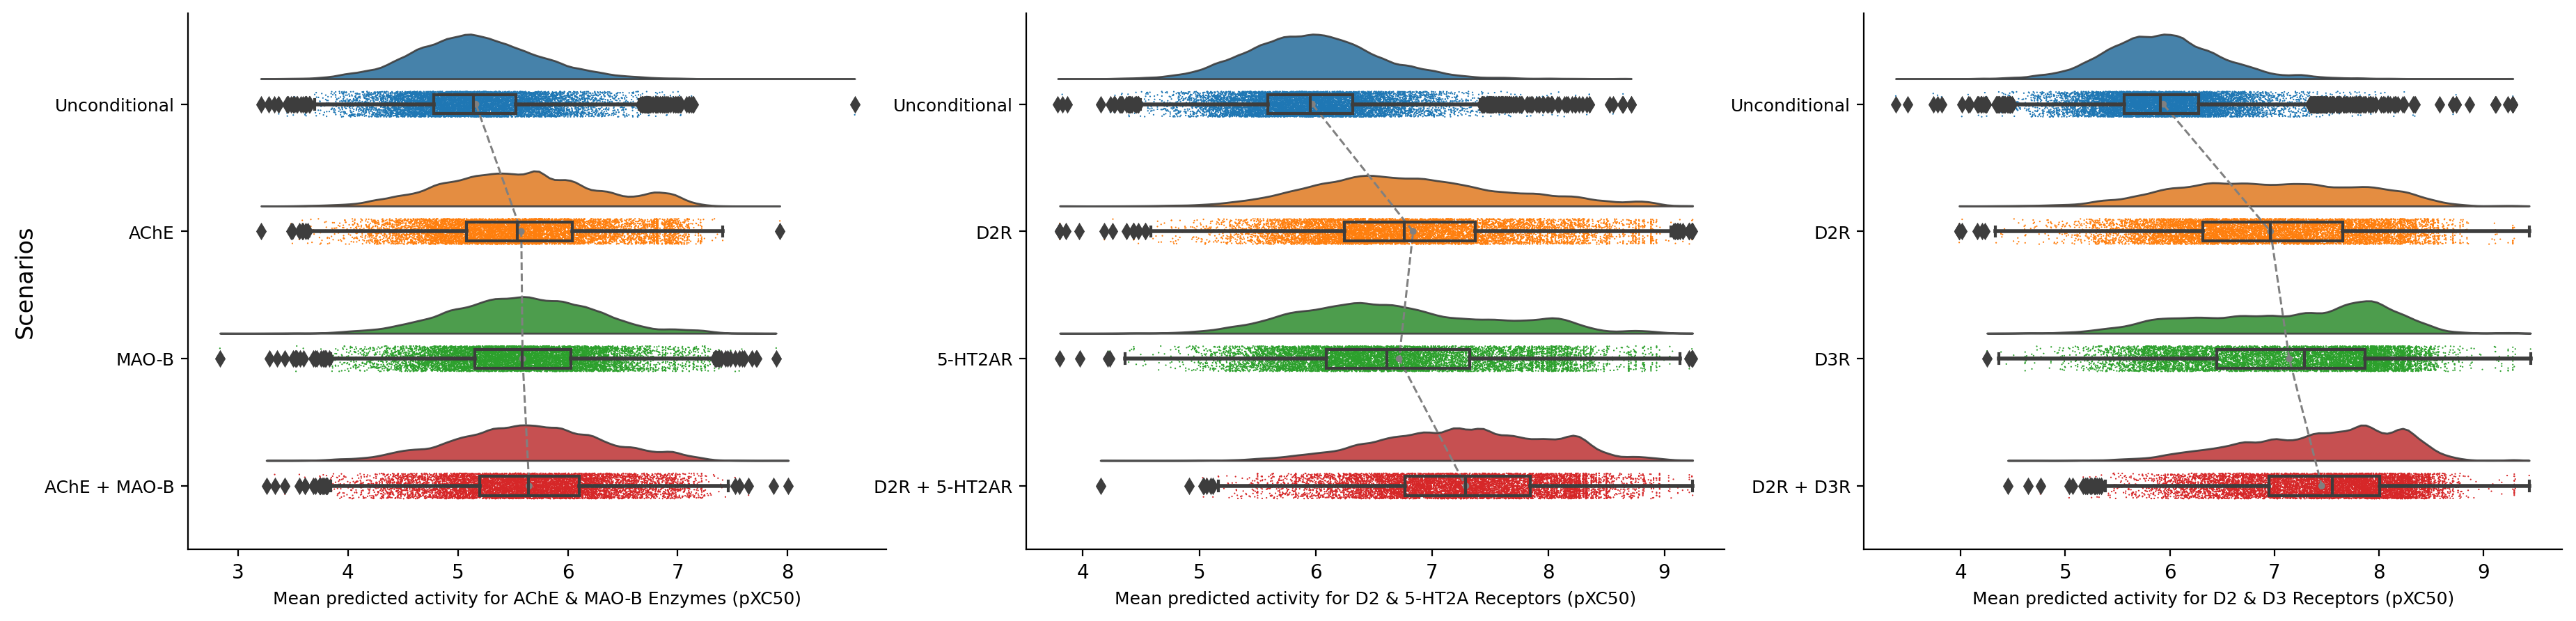

In [3]:
import ptitprince as pt

gen_molecules_labels = {
    "Unconditional": "Unconditional",
    "D2R": "D2R",
    "D3R": "D3R",
    "_5HT2A": "5-HT2AR",
    "D2R__5HT2A_SUM": "D2R + 5-HT2AR",
    "AChE": "AChE",
    "MAOB": "MAO-B",
    "AChE_MAOB_SUM": "AChE + MAO-B",
    "D2R_D3R_SUM": "D2R + D3R",
}

combination_labels = {
    "D2R__5HT2A": "D2 & 5-HT2A Receptors",
    "AChE_MAOB": "AChE & MAO-B Enzymes",
    "D2R_D3R": "D2 & D3 Receptors",
}

agg = "SUM"  # MEAN, MAX
ACT_TYPE = "pXC50"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },

}

# n = 10000
# deep, muted, bright, pastel, dark, colorblind
pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(1, 3, figsize=(22, 5), dpi=200)


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecules_labels.get(gen_molecule, gen_molecule)
        # df_filtered = df[activity_column].sample(n).to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_filtered = df[activity_column].to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[j], palette=pal, 
                 orient="h", alpha=0.9, pointplot=True, point_size=0.8, linecolor='grey', 
                 point_linestyles='--', point_scale=0.4)

    combination_label = combination_labels.get(combination, combination)
    # ax.set_title(f"Molecular activity distribution for {combination_label}", fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    if j == 0:
        axes[j].set_ylabel("Scenarios", fontsize=12)
    else:
        axes[j].set_ylabel("")
    axes[j].set_xlabel(f"Mean predicted activity for {combination_label} ({ACT_TYPE})", fontsize=9)
    axes[j].set_yticklabels(axes[j].get_yticklabels(), fontsize=9)

plt.show()

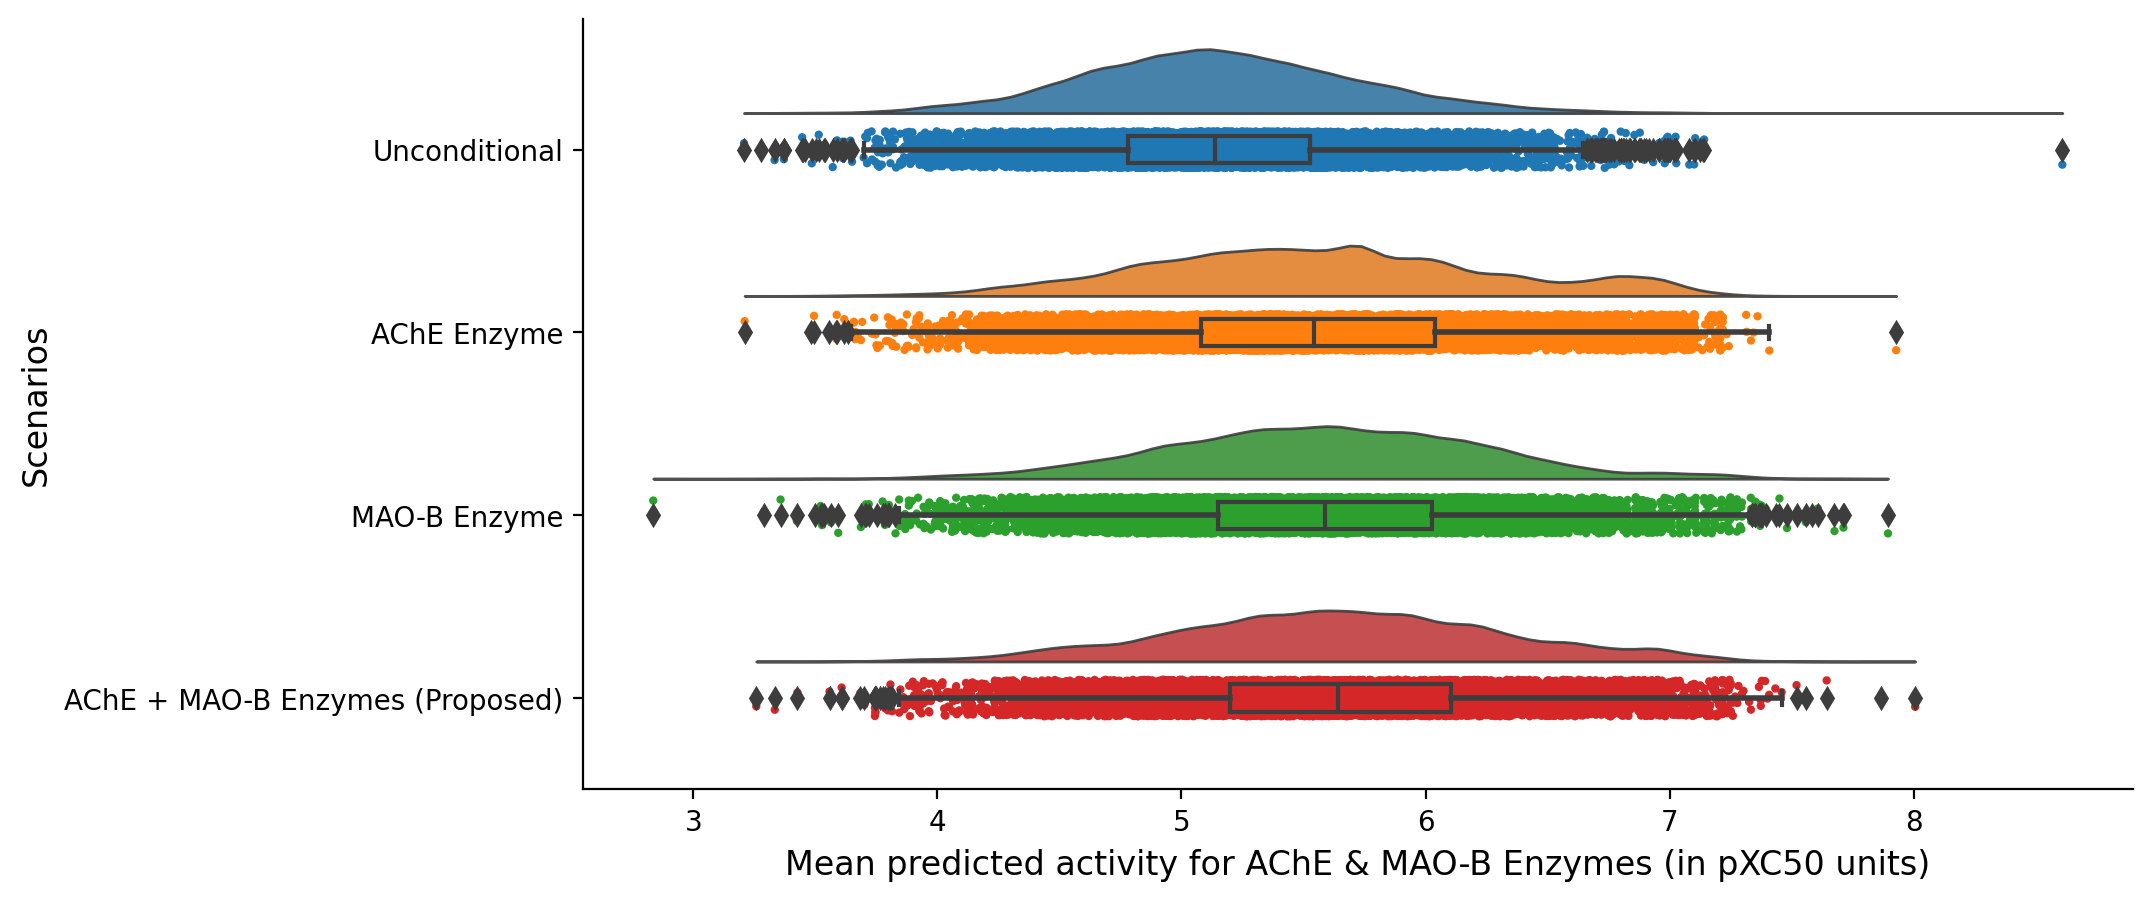

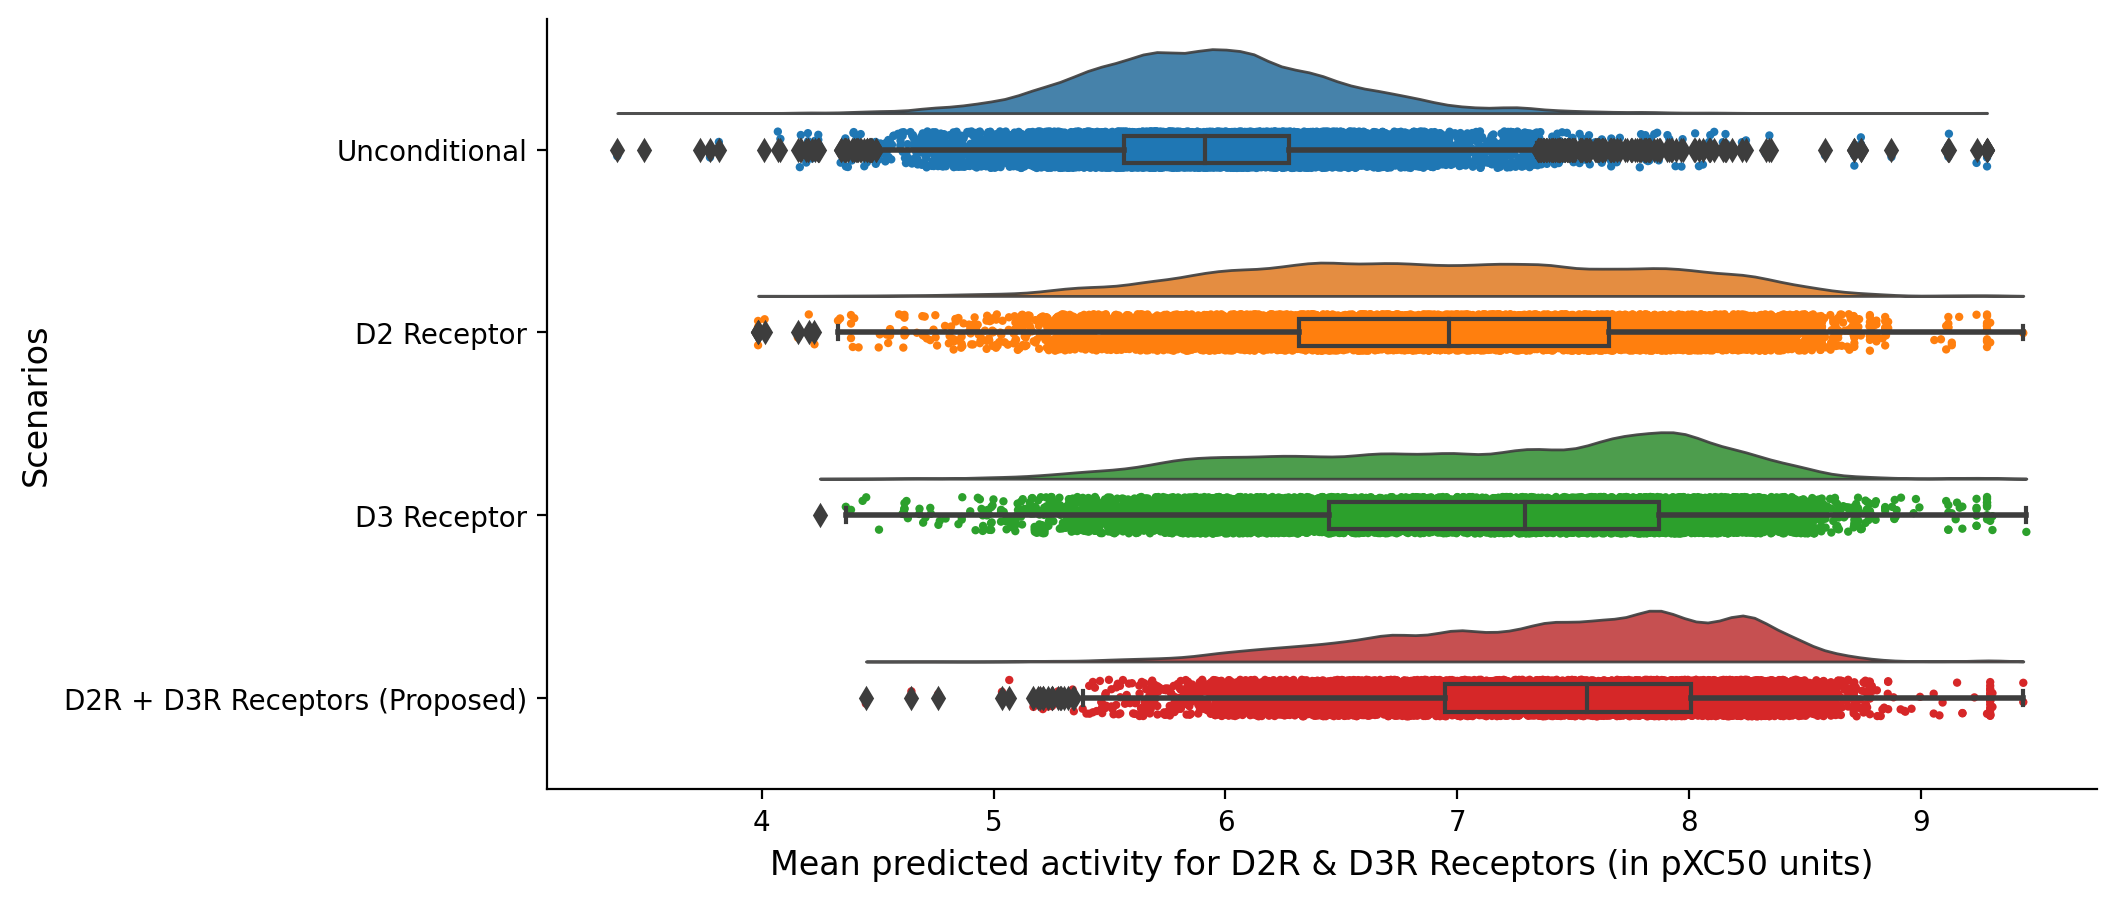

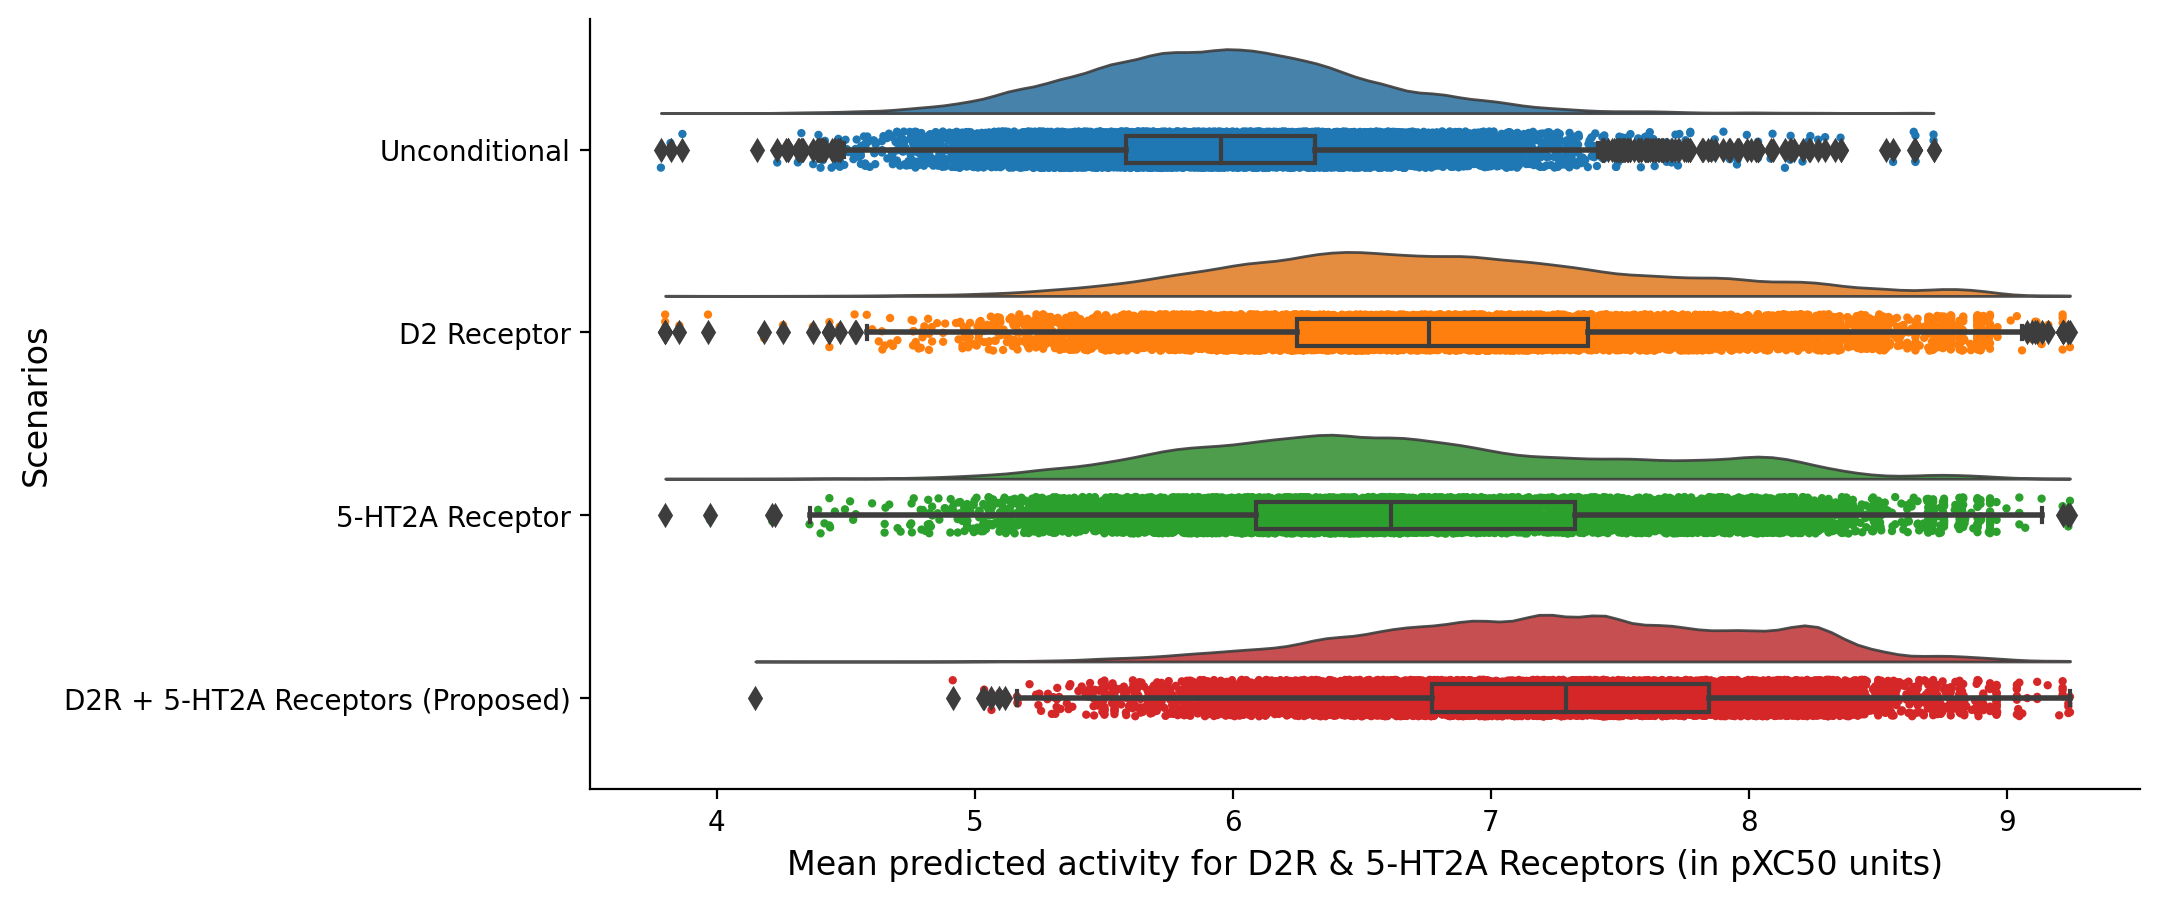

In [4]:
import ptitprince as pt

gen_molecules_labels = {
    "Unconditional": "Unconditional",
    "D2R": "D2 Receptor",
    "D3R": "D3 Receptor",
    "_5HT2A": "5-HT2A Receptor",
    "D2R__5HT2A_SUM": "D2R + 5-HT2A Receptors (Proposed)",
    "AChE": "AChE Enzyme",
    "MAOB": "MAO-B Enzyme",
    "AChE_MAOB_SUM": "AChE + MAO-B Enzymes (Proposed)",
    "D2R_D3R_SUM": "D2R + D3R Receptors (Proposed)",
}

combination_labels = {
    "D2R__5HT2A": "D2R & 5-HT2A Receptors",
    "AChE_MAOB": "AChE & MAO-B Enzymes",
    "D2R_D3R": "D2R & D3R Receptors",
}

agg = "SUM"  # MEAN, MAX
# agg = "MAX"  # MEAN, MAX
# ACT_TYPE = "Activity"  # pIC50, inhibition
ACT_TYPE = "pXC50"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
}

# n = 10000
# deep, muted, bright, pastel, dark, colorblind
pal=list(sns.color_palette("tab10"))

for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    fig, ax = plt.subplots(1, 1, figsize=(10, 5 * 1), dpi=200)

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecules_labels.get(gen_molecule, gen_molecule)
        # df_filtered = df[activity_column].sample(n).to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_filtered = df[activity_column].to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=ax, palette=pal, 
                 orient="h", alpha=0.9) # , pointplot=True, point_size=1)

    combination_label = combination_labels.get(combination, combination)
    # ax.set_title(f"Molecular activity distribution for {combination_label}", fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Scenarios", fontsize=12)
    ax.set_xlabel(f"Mean predicted activity for {combination_label} (in {ACT_TYPE} units)", fontsize=12)

    plt.show()

In [5]:
pivots_combinations = dict()
pivots = pd.DataFrame()

gen_molecules_labels = {
    "Unconditional": "Unconditional",
    "D2R": "D2R",
    "D3R": "D3R",
    "_5HT2A": "5-HT2AR",
    "5HT2A": "5-HT2AR",
    "D2R__5HT2A_SUM": "D2R + 5-HT2AR (Sum)",
    "AChE": "AChE",
    "MAOB": "MAO-B",
    "AChE_MAOB_SUM": "AChE + MAO-B (Sum)",
    "D2R_D3R_SUM": "D2R + D3R (Sum)",
}

for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecules_labels.get(gen_molecule, gen_molecule)
        # scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        # df_filtered = df[activity_column].sample(n).to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_filtered = df[activity_column].to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    pivot = pivot.rename(columns={'mean': 'Mean (pXC50)', 'std': 'Std Deviation (pXC50)'})
    pivot = pivot.sort_values(by=('Mean (pXC50)', activity_column), ascending=False)

    pivots_combinations[combination] = pivot

    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"
    # print(f"Combination: {combination}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"{combination} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))
    pivot.columns = pivot.columns.droplevel(1)
    pivots = pd.concat([pivots, pivot])

,Mean (pXC50),Std Deviation (pXC50)
,AChE_MAOB_pXC50,AChE_MAOB_pXC50
Scenario,,
AChE + MAO-B (Sum),5.65,0.68
MAO-B,5.59,0.64
AChE,5.58,0.71
Unconditional,5.16,0.56


,Mean (pXC50),Std Deviation (pXC50)
,D2R_D3R_pXC50,D2R_D3R_pXC50
Scenario,,
D2R + D3R (Sum),7.45,0.72
D3R,7.14,0.87
D2R,6.96,0.87
Unconditional,5.94,0.58


,Mean (pXC50),Std Deviation (pXC50)
,D2R__5HT2A_pXC50,D2R__5HT2A_pXC50
Scenario,,
D2R + 5-HT2AR (Sum),7.29,0.73
D2R,6.84,0.84
5-HT2AR,6.72,0.86
Unconditional,5.97,0.57


In [6]:
for combination in pivots_combinations:
    pivot = pivots_combinations[combination]
    activity_column = f"{combination}_{ACT_TYPE}"
    gen_molecules = multitarget_combination[combination]["generated_molecules"]

    multitarget_key = [gen_molecules_labels[model] for model in gen_molecules if combination in model][0]
    multitarget_mean = pivot.loc[multitarget_key, 'Mean (pXC50)']

    # Compare multitarget_key with the rest of the models
    for model in gen_molecules:
        if model.startswith("_"):
            model = model[1:]

        if gen_molecules_labels[model] == multitarget_key:
            continue

        mean_model = pivot.loc[gen_molecules_labels[model], 'Mean (pXC50)']
        abs_diff = multitarget_mean - mean_model
        diff = (abs_diff) / mean_model

        if diff > 0:
            print(f"{multitarget_key} is better than {model} by {diff:.2%} ({abs_diff:.2f})")
        else:
            print(f"{multitarget_key} is worse than {model} by {diff:.2%} ({abs_diff:.2f})")

    print()

AChE + MAO-B (Sum) is better than Unconditional by 9.39% (0.48)
AChE + MAO-B (Sum) is better than AChE by 1.28% (0.07)
AChE + MAO-B (Sum) is better than MAOB by 1.07% (0.06)

D2R + D3R (Sum) is better than Unconditional by 25.54% (1.52)
D2R + D3R (Sum) is better than D2R by 7.04% (0.49)
D2R + D3R (Sum) is better than D3R by 4.35% (0.31)

D2R + 5-HT2AR (Sum) is better than Unconditional by 22.11% (1.32)
D2R + 5-HT2AR (Sum) is better than D2R by 6.62% (0.45)
D2R + 5-HT2AR (Sum) is better than 5HT2A by 8.53% (0.57)



### Proportion of molecules in each potency group for each scenario

In [7]:
# Active molecules rule:
# - pXC50 < 6 = Low
# - 6 <= pXC50 < 7 = Medium
# - 7 <= pXC50 < 8 = High
# - pXC50 >= 8 = Ultra High
column_order = ["Low", "Medium", "High", "Ultra High"]
# column_order = ["Low", "Medium", "High/Ultra High"]

def activity_level(pXC50):
    if pXC50 < 6:
        return "Low"
    elif 6 <= pXC50 < 7:
        return "Medium"
    elif 7 <= pXC50 < 8:
        return "High"
    else:
        return "Ultra High"
        # return "High/Ultra High"


full_comparison = pd.DataFrame()

for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        # df_filtered = df[activity_column].sample(n).to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_filtered = df[activity_column].to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index(drop=True)
    activities["Activity Level"] = activities[activity_column].apply(activity_level)

    pivot = activities.pivot_table(index='Scenario', columns='Activity Level', values=activity_column, aggfunc='count')
    pivot = pivot.fillna(0).astype(int)
    # Normalize the counts
    pivot = pivot.div(pivot.sum(axis=1), axis=0)
    # Scenario order (multi-target, single-target, unconditional)
    multi_target_scenario = [model for model in gen_molecules if combination in model][0]
    unconditional_scenario = "Unconditional"
    scenario_order = [multi_target_scenario] + [
        model for model in gen_molecules if model not in [multi_target_scenario, unconditional_scenario]
    ] + [unconditional_scenario]
    scenario_order = [scenario[1:] if scenario.startswith("_") else scenario for scenario in scenario_order]

    column_order_subset = [c for c in column_order if c in pivot.columns]

    display(pivot[column_order].T[scenario_order].style
            .format("{:.1%}")
            .background_gradient(cmap='Blues', axis=1)
            .set_caption(f"{combination} activity level statistics"))
    
    full_comparison = pd.concat([full_comparison, pivot[column_order_subset].T[scenario_order]], axis=1)

Scenario,AChE_MAOB_SUM,AChE,MAOB,Unconditional
Activity Level,,,,
Low,70.3%,73.4%,73.7%,92.5%
Medium,27.5%,24.7%,24.4%,7.4%
High,2.1%,1.9%,2.0%,0.1%
Ultra High,0.0%,0.0%,0.0%,0.0%


Scenario,D2R_D3R_SUM,D2R,D3R,Unconditional
Activity Level,,,,
Low,3.0%,14.4%,13.0%,56.8%
Medium,24.2%,36.9%,28.2%,39.3%
High,47.2%,35.1%,41.8%,3.6%
Ultra High,25.5%,13.6%,17.0%,0.3%


Scenario,D2R__5HT2A_SUM,D2R,5HT2A,Unconditional
Activity Level,,,,
Low,4.2%,15.2%,21.3%,53.5%
Medium,31.4%,45.9%,45.2%,42.4%
High,44.9%,28.4%,23.5%,3.7%
Ultra High,19.5%,10.5%,10.1%,0.3%


In [8]:
# print(full_comparison.rename(columns={
#     "AChE_MAOB_SUM": "AChE + MAO-B",
#     "D2R_D3R_SUM": "D2R + D3R",
#     "D2R__5HT2A_SUM": "D2R + 5-HT2A"
# }).T.to_csv())

full_comparison.rename(columns={
    "AChE_MAOB_SUM": "AChE + MAO-B",
    "D2R_D3R_SUM": "D2R + D3R",
    "D2R__5HT2A_SUM": "D2R + 5-HT2A"
}).T

Activity Level,Low,Medium,High,Ultra High
Scenario,,,,
AChE + MAO-B,0.703166,0.275260,0.021466,0.000108
AChE,0.733935,0.247152,0.018913,0.000000
MAOB,0.736858,0.243532,0.019610,0.000000
Unconditional,0.925138,0.073720,0.001038,0.000104
D2R + D3R,0.030395,0.242293,0.471823,0.255489
D2R,0.143613,0.369410,0.351250,0.135727
D3R,0.130220,0.282297,0.417981,0.169502
Unconditional,0.568061,0.392794,0.035926,0.003219
D2R + 5-HT2A,0.041575,0.314333,0.448906,0.195186


### Statistical test

The null hypothesis is that the population median of all of the groups are equal
The alternative hypothesis is that at least one population median of the groups are different

Combination: AChE_MAOB
p-value: 0.0000000000e+00
Significant: Reject the null hypothesis
Effect size: 3249.32830392



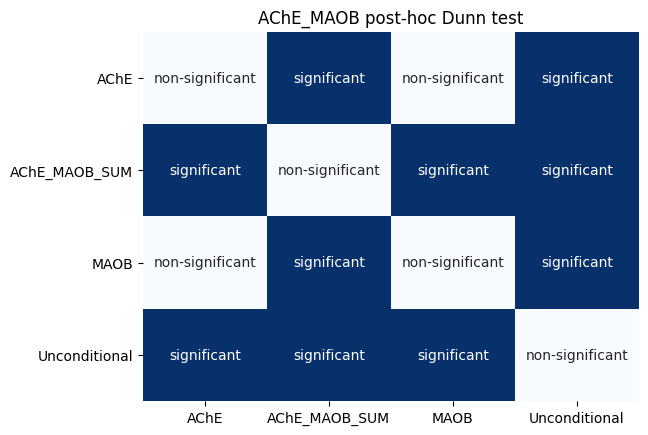

Combination: D2R_D3R
p-value: 0.0000000000e+00
Significant: Reject the null hypothesis
Effect size: 13627.57631489



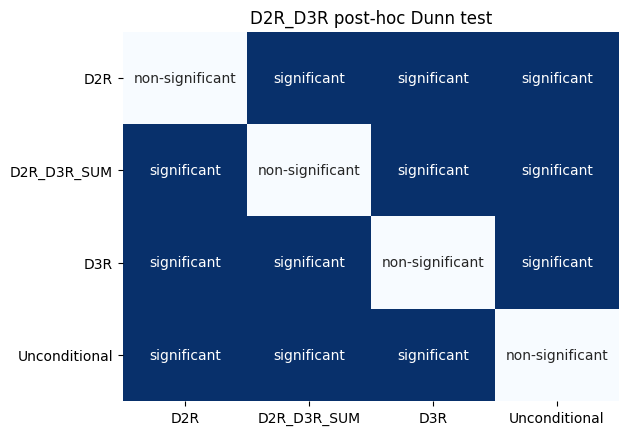

Combination: D2R__5HT2A
p-value: 0.0000000000e+00
Significant: Reject the null hypothesis
Effect size: 11471.74459424



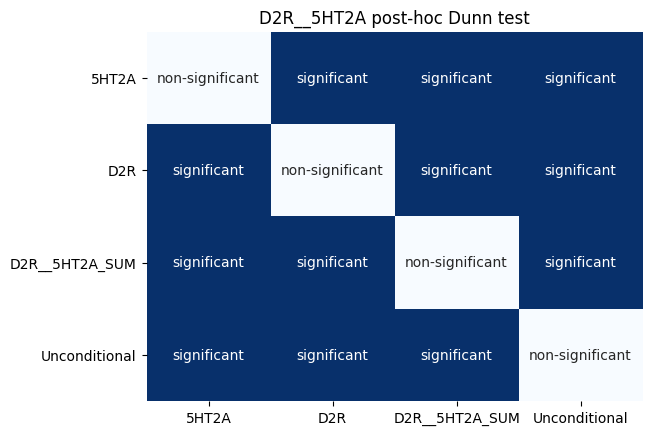

In [9]:
# Kruskal-Wallis H-test
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

print(f"The null hypothesis is that the population median of all of the groups are equal")
print(f"The alternative hypothesis is that at least one population median of the groups are different\n")

for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].to_frame().assign(Scenario=scenario).dropna(subset=[activity_column])
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    unique_scenarios = activities['Scenario'].unique()
    h, p = kruskal(*[activities[activities['Scenario'] == scenario][activity_column] for scenario in unique_scenarios])

    print(f"Combination: {combination}")
    print(f"p-value: {p:.10e}")

    if p < 0.05:
        print("Significant: Reject the null hypothesis")
        print(f"Effect size: {h:.8f}\n")
    else:
        print("Not significant: Fail to reject the null hypothesis\n")

    # Perform a post-hoc test
    posthoc = posthoc_dunn(
        activities, val_col=activity_column, group_col='Scenario', p_adjust='bonferroni'
    )

    ax = sns.heatmap((posthoc < 0.01), annot=True, cmap='Blues', cbar=False)
    plt.title(f"{combination} post-hoc Dunn test")

    # Replace the values with a boolean in the plot
    for t in ax.texts:
        if t.get_text() == '1':
            t.set_text('significant')
        elif t.get_text() == '0':
            t.set_text('non-significant')

    plt.show()